In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import zipfile

def load_data(filename : str, ds : str) -> pd.DataFrame:

    with zipfile.ZipFile(filename, 'r') as zipFile:

        # Obtain a list of all files in the zip archive
        fileList = zipFile.namelist()

        # Filter only files with name in db argument ending with .xls
        targetedFileNames = [file for file in fileList if file.endswith(f'{ds}.xls')]

        df = []

        # Obtain dataframe from each file and append it to the list
        for file in targetedFileNames:
            with zipFile.open(file) as f:
                df.extend(pd.read_html(f, encoding="cp1250"))


        # Concatenate all dataframes into one (ignore index for not using index values from original dataframes)
        df = pd.concat(df, ignore_index=True)

        # Drop unnamed columns containing NaN values
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        return df
# Ukol 2: zpracovani dat


def parse_data(df: pd.DataFrame, verbose: bool = False) -> pd.DataFrame:

    # Define region dictionary for mapping
    regions = {
        0: "PHA", 1: "STC", 2: "JHC", 3: "PLK",
        4: "ULK", 5: "HKK", 6: "JHM", 7: "MSK",
        14: "OLK", 15: "ZLK", 16: "VYS", 17: "PAK",
        18: "LBK", 19: "KVK"
    }

    #Copy the dataframe to avoid SettingWithCopyWarning
    newDf = df.copy()

    # Create new column with date in datetime format
    newDf["date"] = pd.to_datetime(newDf["p2a"], format="%d.%m.%Y", errors="coerce")

    # Create new column with region name based on mapping
    newDf["region"] = newDf["p4a"].map(regions)

    # Drop all duplicates based on p1 column, based on the task description i decided to keep none of the duplicates
    newDf = newDf.drop_duplicates(subset='p1', keep=False)

    # If verbose, print deep memory usage of the dataframe
    if(verbose):
        print(f'new_size={(newDf.memory_usage(deep=True).sum() / (1000 * 1000)):.1f} MB')
    return newDf

In [2]:
df = load_data("data_23_24.zip", "nehody")
df2 = parse_data(df, True)
df_conequences = load_data("data_23_24.zip", "nasledky")

new_size=68.3 MB


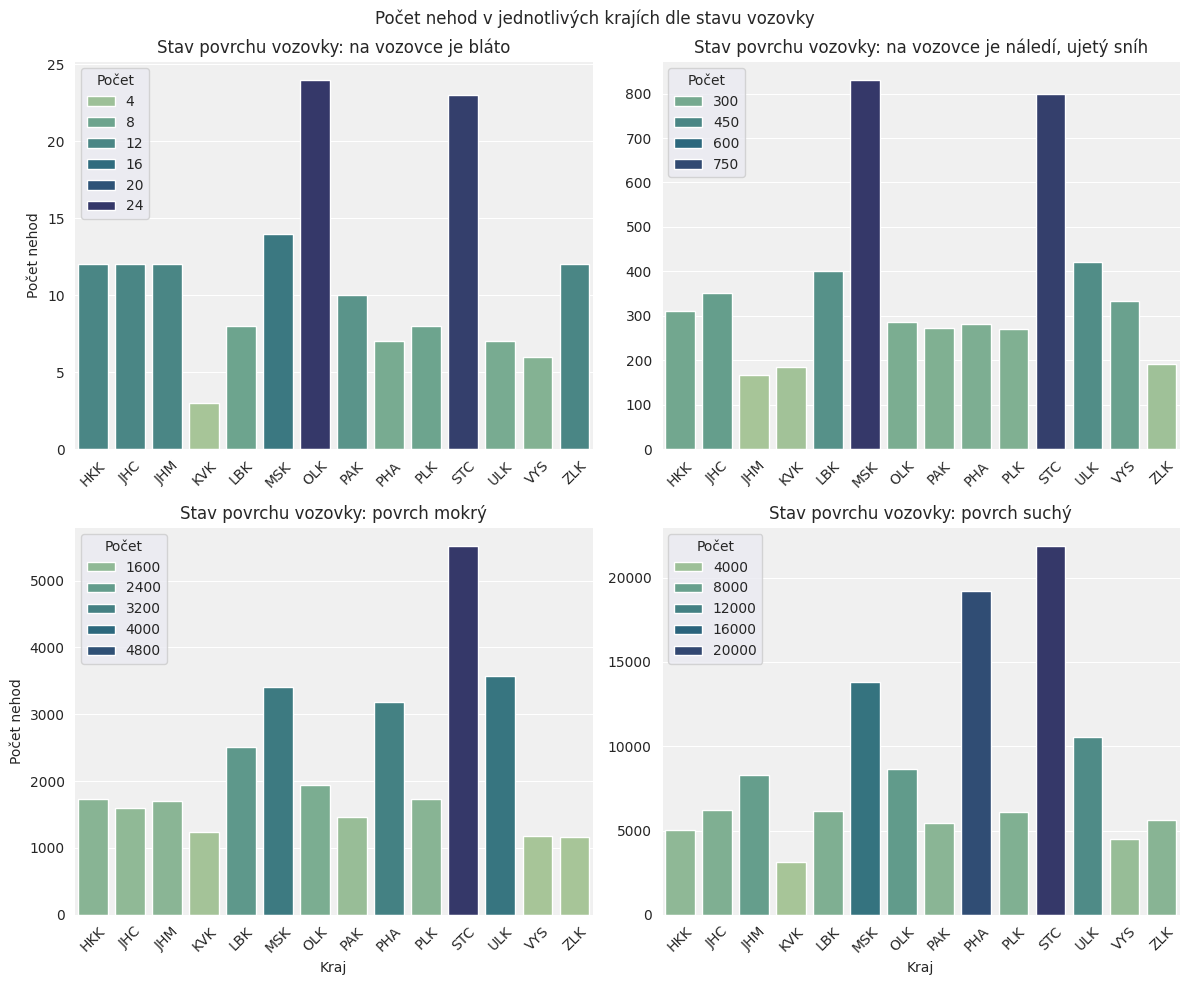

In [ ]:
def plot_state(df: pd.DataFrame, fig_location: str = None,
                    show_figure: bool = False):

    # Define road states dictionary for mapping
    roadStates = {
        1: "povrch suchý",
        2: "povrch suchý",
        3: "povrch mokrý",
        4: "na vozovce je bláto",
        5: "na vozovce je náledí, ujetý sníh",
        6: "na vozovce je náledí, ujetý sníh",
    }

    # Create new column with road state based on mapping
    df["roadStates"] = df["p16"].map(roadStates)

    # Create new subdataset using groupy and size functions
    roadsWithRegions = df.groupby(["region", "roadStates"]).size().reset_index(name="count")

    # Create 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Flatten the grid to a 1D array for iteration
    axes = axes.flatten()

    # Set the title of the figure
    fig.suptitle("Počet nehod v jednotlivých krajích dle stavu vozovky")

    # Obtain all unique road states
    roadStateList = roadsWithRegions["roadStates"].unique()

    """
    For Mr. Mrazek: I decided to iterate over axes and plot new graph using barplot for every subplot.
    I know it would be easier to use just sns.catplot and define colwrap parameter for example to produce less code,
    but in that case i could not use hue in general for all subplots,
    becsuse each subgraph have different number of accidents and hue would not reflect that correctly,
    maybe there is an option of creating custom hue scale for each subgraph, but this option of iterating over axes
    and plotting each subplot separately with its hue seemed more clear to me. Thanks for understanding.
    """
    
    # Iterate over all subplots (roadStates)
    for i, axe in enumerate(axes):

        # Obtain data for current road state
        currentRoadState = roadsWithRegions[roadsWithRegions["roadStates"] == roadStateList[i]]

        # Plot barplot for each subplot with a color palette and hue based on count
        sns.barplot(data=currentRoadState, x="region", y="count", ax=axe, palette="crest", hue="count")

        # Set the style of the plot and background color
        sns.set_style("darkgrid")
        axe.set_facecolor('#f0f0f0')

        # Set the legend title and location
        axe.legend(title="Počet", loc="upper left")
        
        # Set the title of the subplot based on road state
        axe.set_title(f'Stav povrchu vozovky: {roadStateList[i]}')

        # Rotate x axis labels for better readability
        axe.tick_params(axis='x', rotation=45)
        
        # Set labels for x and y axis based on subplot position
        axe.set_xlabel("Kraj" if i >= 2 else "")
        axe.set_ylabel("Počet nehod" if i % 2 == 0 else "")

    # Use tight layout for better spacing
    plt.tight_layout()

    # Save the figure if location is provided
    if(fig_location):
        plt.savefig(fig_location)

    # If True, show the figure
    if(show_figure):
        plt.show()
    


plot_state(df2, "01_state.png")

   region   consequences  driver_hurt  count
0     HKK    bez zranění  spolujezdec     96
1     HKK    bez zranění        řidič    307
2     HKK  lehké zranění  spolujezdec     16
3     HKK  lehké zranění        řidič    142
4     HKK  těžké zranění  spolujezdec      4
..    ...            ...          ...    ...
94    ZLK  lehké zranění  spolujezdec     24
95    ZLK  lehké zranění        řidič    212
96    ZLK  těžké zranění  spolujezdec      1
97    ZLK  těžké zranění        řidič      6
98    ZLK       usmrcení        řidič      1

[99 rows x 4 columns]


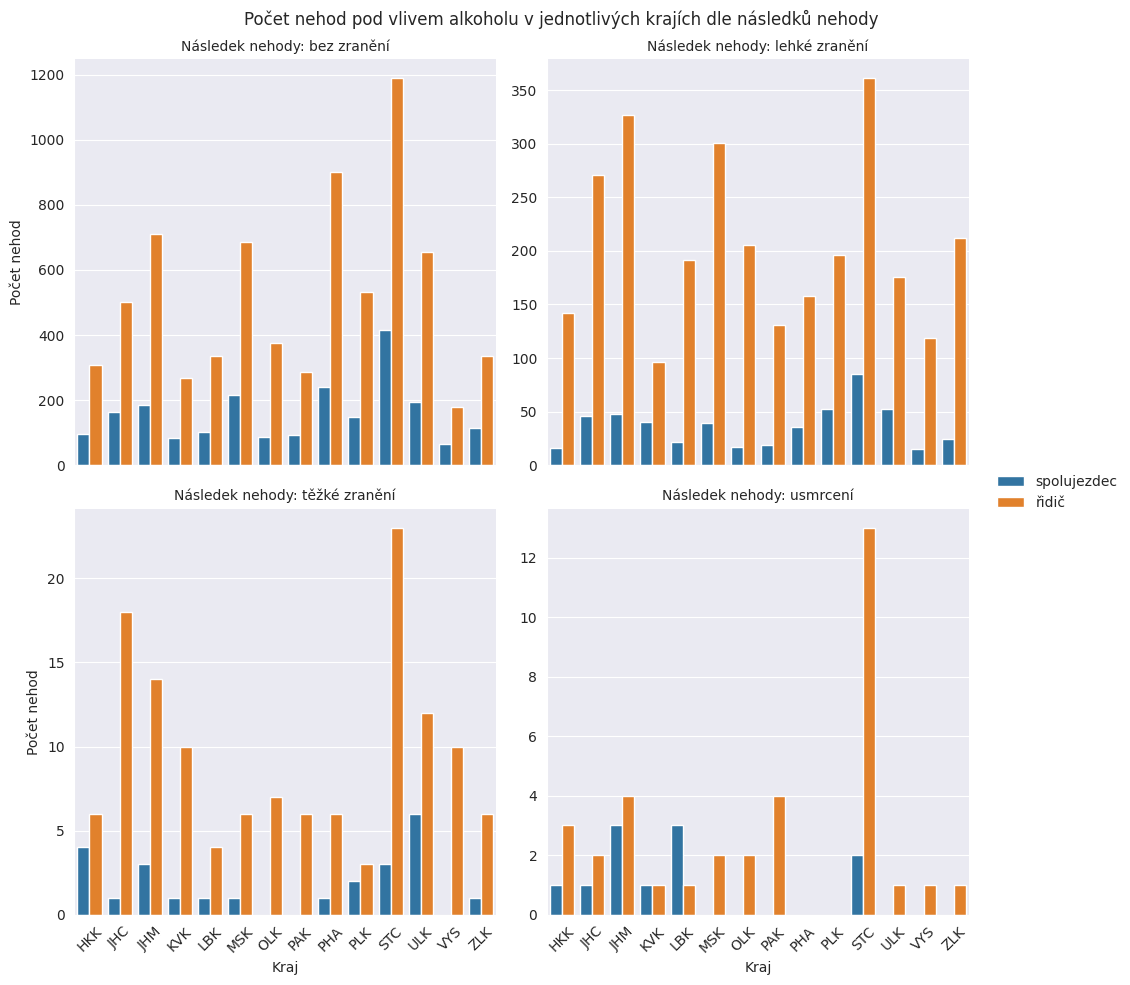

In [ ]:
def plot_alcohol(df: pd.DataFrame, df_consequences : pd.DataFrame, 
                 fig_location: str = None, show_figure: bool = False):
    
    # Merge the dataframes based on p1 column with relation one to many
    dfMerged = pd.merge(df, df_consequences, on="p1", validate="one_to_many")

    # Define dictionary for mapping injury consequences
    injury = {
        1: "usmrcení",
        2: "těžké zranění",
        3: "lehké zranění",
        4: "bez zranění",
    }
    
    # Create a column driver_hurt based on p59a column value (1 - driver, 2 - passenger)
    dfMerged["driver_hurt"] = dfMerged["p59a"].apply(lambda x: "řidič" if x == 1 else "spolujezdec")

    # Create a column consequences and map it based on injury dictionary
    dfMerged["consequences"] = dfMerged["p59g"].map(injury)

    # Create a new dataframe with only accidents where alcohol was involved
    dfAlcoholOnly = dfMerged[dfMerged["p11"] >= 3]

    # Aggregate the data based on region, consequences and driver_hurt columns
    groupedDf = dfAlcoholOnly.groupby(["region", "consequences", "driver_hurt"]).size().reset_index(name="count")
    print(groupedDf)

    # Create a catplot with 2x2 grid of subplots where each subplot represents a different consequence of the accident
    g = sns.catplot(data=groupedDf, x="region", y="count", hue="driver_hurt", col="consequences", kind="bar", palette="tab10", col_wrap=2, sharey=False)

    # Set the style of the plot
    sns.set_style("darkgrid")

    # Set the title of the figure
    g.figure.suptitle("Počet nehod pod vlivem alkoholu v jednotlivých krajích dle následků nehody")

    # Set the tittle of each subplot based on the consequence
    g.set_titles("Následek nehody: {col_name}")
    
    # Remove the legend title
    g.legend.set_title("")

    # Set the labels for x and y axis
    g.set_xlabels("Kraj")
    g.set_ylabels("Počet nehod")
    
    # Rotate x axis labels for better readability
    g.tick_params(axis='x', rotation=45)

    # Use tight layout for better spacing
    g.tight_layout()

    # Save the figure if location is provided
    if fig_location:
        plt.savefig(fig_location)

    # If True, show the figure
    if show_figure:
        plt.show()
    
    


plot_alcohol(df2, df_conequences, "02_alcohol.png", True)

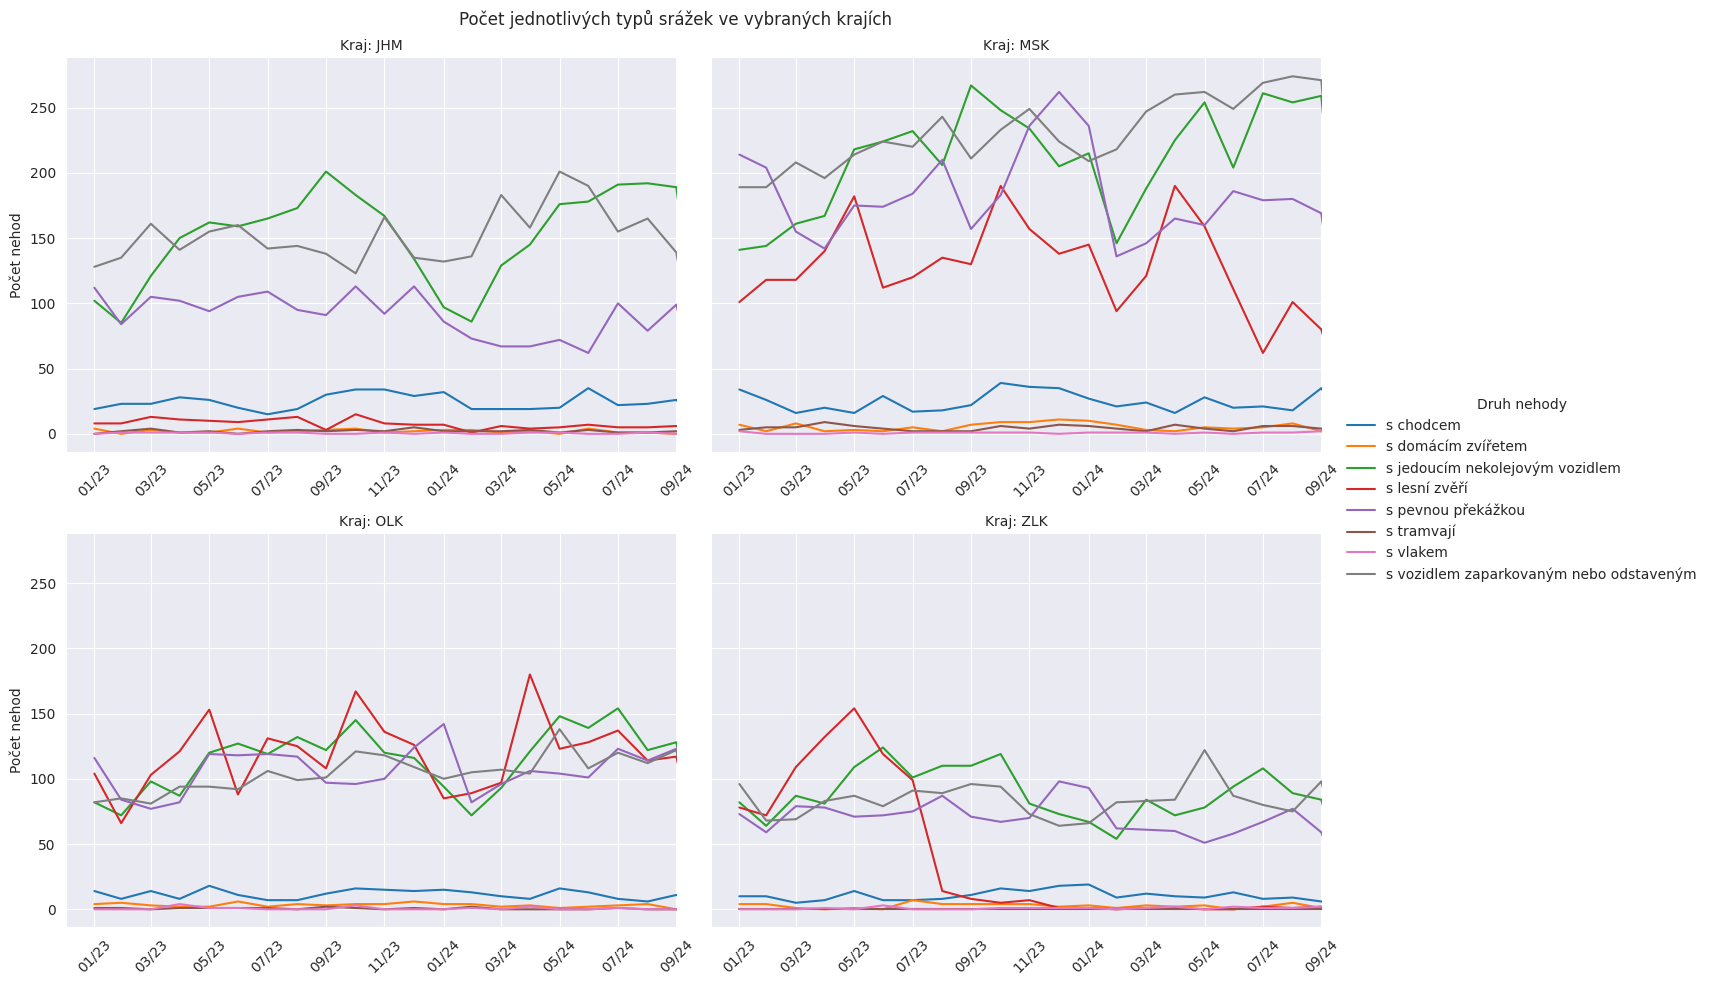

In [ ]:
def plot_type(df: pd.DataFrame, fig_location: str = None,
              show_figure: bool = False):
    
    #Filter only 4 chosen regions
    dfFiltered = df[df["region"].isin(["OLK", "MSK", "JHM", "ZLK"])]

    accidentType = {
        1: "s jedoucím nekolejovým vozidlem",
        2: "s vozidlem zaparkovaným nebo odstaveným",
        3: "s pevnou překážkou",
        4: "s chodcem",
        5: "s lesní zvěří",
        6: "s domácím zvířetem",
        7: "s vlakem",
        8: "s tramvají",
    }

    #Copy the dataframe to avoid SettingWithCopyWarning
    dfFiltered = dfFiltered.copy()

    #Map the accident type to the dataframe's new column
    dfFiltered["accidentType"] = dfFiltered["p6"].map(accidentType)

    #Create a pivot table with date and region as a multiindex
    dfPivoted = pd.pivot_table(dfFiltered, index=["date", "region"], columns="accidentType", values="p6", aggfunc="count", fill_value=0)

    #Use downsampling to get the data in monthly intervals
    dfResampled = dfPivoted.groupby("region").resample("ME", level="date").sum()

    #Stack the dataframe to get the data in the right format for plotting
    dfToPlot = dfResampled.stack().reset_index(name="count")
    # print(dfToPlot)

    #Create a relplot with "line" kind to plot the data in different regions
    g = sns.relplot(data=dfToPlot, x="date", y="count", hue="accidentType", col="region", kind="line", palette="tab10", col_wrap=2)

    #Move the legend to the right side of the subgraphs
    sns.move_legend(g, "center right", title="Druh nehody", bbox_to_anchor=(1.26, 0.5))

    #Set the title of the whole figure
    g.figure.suptitle("Počet jednotlivých typů srážek ve vybraných krajích")

    #Set the title of each subgraph
    g.set_titles("Kraj: {col_name}")

    #set y axe label
    g.set_ylabels("Počet nehod")

    #Set the x axe labes to empty
    g.set_xlabels("")

    #Set the xtics with two months interval
    xticks = pd.date_range(start='2023-01-01', end='2024-10-01', freq='2ME')

    #Set the x axe limit for each subgraph and convert the xticks to the right format
    for ax in g.axes.flat:
        ax.set_xlim(pd.Timestamp("2023-01-01"), pd.Timestamp("2024-10-01"))
        ax.tick_params(axis='x', labelbottom=True, rotation=45)
        #Taken from IZV lectures
        ax.set_xticks(xticks)
        ax.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%m/%y') for tm in xticks])


    #Use tight_layout to avoid overlapping of the subgraphs
    plt.tight_layout()

    #Save the figure if the location is given
    if fig_location:
        plt.savefig(fig_location)

    #show the figure if True
    if show_figure:
        plt.show()

plot_type(df2, "03_type.png", True)